In [3]:
!pip install kagglehub

   ---------------------------------------- 0.0/68.0 kB ? eta -:--:--
   ------------------------ --------------- 41.0/68.0 kB ? eta -:--:--
   ---------------------------------------- 68.0/68.0 kB 1.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vijayvvenkitesh/microsoft-stock-time-series-analysis")

print("Path to dataset files:", path)

100%|██████████████████████████████████████████████████████████████████████████████| 26.7k/26.7k [00:00<00:00, 327kB/s]

Extracting files...
Path to dataset files: C:\Users\Shrinil\.cache\kagglehub\datasets\vijayvvenkitesh\microsoft-stock-time-series-analysis\versions\1


In [4]:
df=pd.read_csv('Microsoft_stock.csv')

In [5]:
df.head(10)

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
5,4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861
6,4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002
7,4/13/2015 16:00:00,41.40,42.06,41.39,41.76,30276692
8,4/14/2015 16:00:00,41.80,42.03,41.39,41.65,24244382
9,4/15/2015 16:00:00,41.76,42.46,41.68,42.26,27343581


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [7]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [8]:
df.shape

(1511, 6)

In [9]:
df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


In [10]:
df.duplicated().sum()

0

In [31]:
X=df[['Open','High','Low','Volume']]

In [32]:
y=df[['Close']]

In [33]:
X.shape,y.shape

((1511, 4), (1511, 1))

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
X_scaler=StandardScaler()
y_scaler=StandardScaler()

In [36]:
scaled_X=X_scaler.fit_transform(X)
scaled_y=y_scaler.fit_transform(y)

In [39]:
def create_seq(X,y,time_steps):
    Xs,ys=[],[]
    for i in range(len(X)-time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.asarray(Xs),np.asarray(ys)

In [46]:
X_seq,y_seq=create_seq(scaled_X,scaled_y,7)

In [47]:
print(X_seq.shape) #elements, time steps , features

(1504, 7, 4)


In [48]:
print(y_seq.shape)

(1504, 1)


In [49]:
split=int(len(X_seq)*0.8)
split

1203

In [50]:
X_train=X_seq[:split]
y_train=y_seq[:split]

In [51]:
X_test=X_seq[split:]
y_test=y_seq[split:]

In [52]:
X_train.shape,y_train.shape

((1203, 7, 4), (1203, 1))

In [53]:
X_test.shape,y_test.shape

((301, 7, 4), (301, 1))

In [54]:
from torch.utils.data import Dataset

In [55]:
class TSFData(Dataset):
    def __init__(self,X,y):
        self.X=X
        self.y=y

    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i],self.y[i]

In [56]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32).to(device)
X_test_tensor=torch.tensor(X_test,dtype=torch.float32).to(device)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32).to(device)
y_test_tensor=torch.tensor(y_test,dtype=torch.float32).to(device)

In [57]:
train_data=TSFData(X_train_tensor,y_train_tensor)
test_data=TSFData(X_test_tensor,y_test_tensor)

In [58]:
len(train_data)

1203

In [59]:
len(test_data)

301

In [60]:
from torch.utils.data import DataLoader

In [61]:
train_dataloader=DataLoader(train_data,batch_size=16,shuffle=False)

In [62]:
test_dataloader=DataLoader(test_data,batch_size=16,shuffle=False)

In [63]:
# DEF LSTM MODEL CLASS

In [64]:
len(train_dataloader)

76

In [65]:
len(test_dataloader)

19

In [66]:
for idx,(X,y) in enumerate(train_dataloader):
    print(X[idx])
    print(y[idx])
    print(X[idx].shape)
    print(y[idx].shape)
    break

tensor([[-1.1785, -1.1798, -1.1792,  0.4679],
        [-1.1774, -1.1802, -1.1826,  0.5116],
        [-1.1830, -1.1620, -1.1815,  0.6334],
        [-1.1606, -1.1598, -1.1613, -0.0975],
        [-1.1629, -1.1636, -1.1661, -0.3822],
        [-1.1670, -1.1648, -1.1624, -0.3141],
        [-1.1603, -1.1591, -1.1595, -0.1528]], device='cuda:0')
tensor([-1.1584], device='cuda:0')
torch.Size([7, 4])
torch.Size([1])


In [67]:
import torch.nn as nn
from torch.optim import Adam as Adam

In [106]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers):
        super().__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,bidirectional=False,batch_first=True)
        self.fc=nn.Sequential(
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(hidden_size,1)
        )

    def forward(self,x):
        batch_size = x.size(0)
        h0=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out
    

In [116]:
model_0=LSTM(4,64,1).to(device)

In [117]:
loss_fn=nn.MSELoss()
optim=Adam(params=model_0.parameters(),lr=0.01)

In [118]:
#def traininng loop function
def train_loop(epochs,model,dataloader,loss_fn,optimizer,device):
    model.train()
    for epoch in range(epochs):
        train_loss=0
        for i,(X,y) in enumerate(dataloader):
            X=X.to(device)
            y=y.to(device)
            y_pred=model(X)
            loss=loss_fn(y_pred,y)
            train_loss+=loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(dataloader):.4f}")

    

In [119]:
train_loop(50,model_0,train_dataloader,loss_fn,optim,device)

Epoch 1/50, Loss: 0.0774
Epoch 2/50, Loss: 0.1770
Epoch 3/50, Loss: 0.1467
Epoch 4/50, Loss: 0.0878
Epoch 5/50, Loss: 0.1076
Epoch 6/50, Loss: 0.0375
Epoch 7/50, Loss: 0.0202
Epoch 8/50, Loss: 0.0201
Epoch 9/50, Loss: 0.0194
Epoch 10/50, Loss: 0.0234
Epoch 11/50, Loss: 0.0149
Epoch 12/50, Loss: 0.0208
Epoch 13/50, Loss: 0.0413
Epoch 14/50, Loss: 0.0172
Epoch 15/50, Loss: 0.0158
Epoch 16/50, Loss: 0.0227
Epoch 17/50, Loss: 0.0269
Epoch 18/50, Loss: 0.0112
Epoch 19/50, Loss: 0.0188
Epoch 20/50, Loss: 0.0170
Epoch 21/50, Loss: 0.0098
Epoch 22/50, Loss: 0.0137
Epoch 23/50, Loss: 0.0185
Epoch 24/50, Loss: 0.0086
Epoch 25/50, Loss: 0.0082
Epoch 26/50, Loss: 0.0118
Epoch 27/50, Loss: 0.0166
Epoch 28/50, Loss: 0.0156
Epoch 29/50, Loss: 0.0102
Epoch 30/50, Loss: 0.0077
Epoch 31/50, Loss: 0.0102
Epoch 32/50, Loss: 0.0125
Epoch 33/50, Loss: 0.0082
Epoch 34/50, Loss: 0.0109
Epoch 35/50, Loss: 0.0191
Epoch 36/50, Loss: 0.0079
Epoch 37/50, Loss: 0.0147
Epoch 38/50, Loss: 0.0306
Epoch 39/50, Loss: 0.

In [92]:
import matplotlib.pyplot as plt
import numpy as np

def predict_and_plot(model, dataloader, x_scaler, y_scaler, device):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Perform forward pass
            y_pred = model(X)

            # Collect predictions and actual targets for inverse scaling
            predictions.append(y_pred.cpu().numpy())
            targets.append(y.cpu().numpy())

    # Combine all the predictions and targets
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    # Perform inverse scaling on the predictions and targets
    predictions = y_scaler.inverse_transform(predictions)
    targets = y_scaler.inverse_transform(targets)

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.plot(targets, label='Actual', color='blue', alpha=0.7)
    plt.plot(predictions, label='Predicted', color='red', linestyle='dashed', alpha=0.7)
    plt.title('Predictions vs Actuals (Test Data)')
    plt.xlabel('Samples')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    return predictions, targets


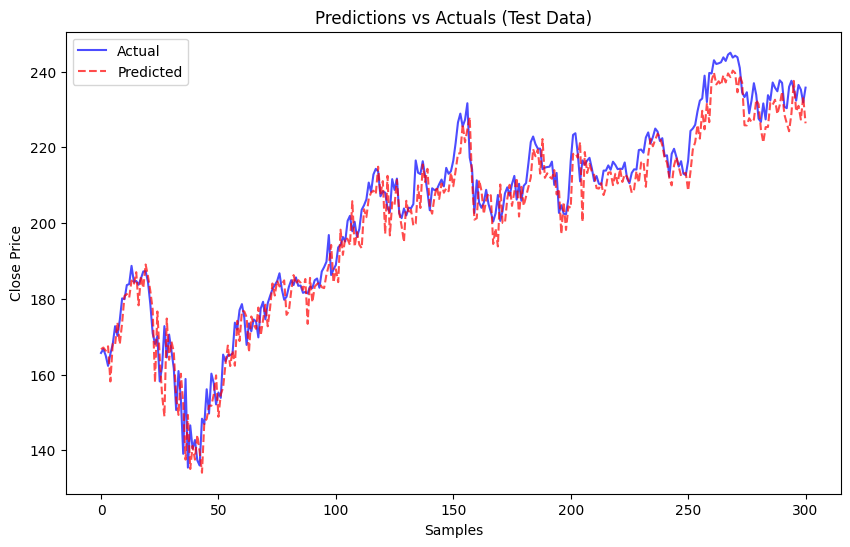

In [129]:
preds,targets=predict_and_plot(model_0,test_dataloader,X_scaler,y_scaler,device)

In [123]:
!pip install torchmetrics torchinfo

   ---------------------------------------- 0.0/961.5 kB ? eta -:--:--
   - ------------------------------------- 41.0/961.5 kB 991.0 kB/s eta 0:00:01
   ----- ---------------------------------- 143.4/961.5 kB 1.7 MB/s eta 0:00:01
   -------- ------------------------------- 194.6/961.5 kB 2.0 MB/s eta 0:00:01
   ----------- ---------------------------- 276.5/961.5 kB 1.5 MB/s eta 0:00:01
   --------------- ------------------------ 368.6/961.5 kB 1.6 MB/s eta 0:00:01
   ------------------ --------------------- 440.3/961.5 kB 1.7 MB/s eta 0:00:01
   --------------------- ------------------ 522.2/961.5 kB 1.7 MB/s eta 0:00:01
   ------------------------ --------------- 583.7/961.5 kB 1.6 MB/s eta 0:00:01
   -------------------------- ------------- 645.1/961.5 kB 1.6 MB/s eta 0:00:01
   ---------------------------- ----------- 696.3/961.5 kB 1.5 MB/s eta 0:00:01
   ---------------------------------- ----- 829.4/961.5 kB 1.6 MB/s eta 0:00:01
   ------------------------------------- -- 901.1

In [124]:
from torchinfo import summary

In [130]:
summary(model_0,input_size=(16,7,4))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [16, 1]                   --
├─LSTM: 1-1                              [16, 7, 64]               17,920
├─Sequential: 1-2                        [16, 1]                   --
│    └─Dropout: 2-1                      [16, 64]                  --
│    └─ReLU: 2-2                         [16, 64]                  --
│    └─Linear: 2-3                       [16, 1]                   65
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.07
Estimated Total Size (MB): 0.13

In [138]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [147]:
print(mean_absolute_error(preds,targets))

4.699007


In [148]:
print(mean_squared_error(preds,targets))

35.541893


In [149]:
print(r2_score(preds,targets))

0.9404014348983765


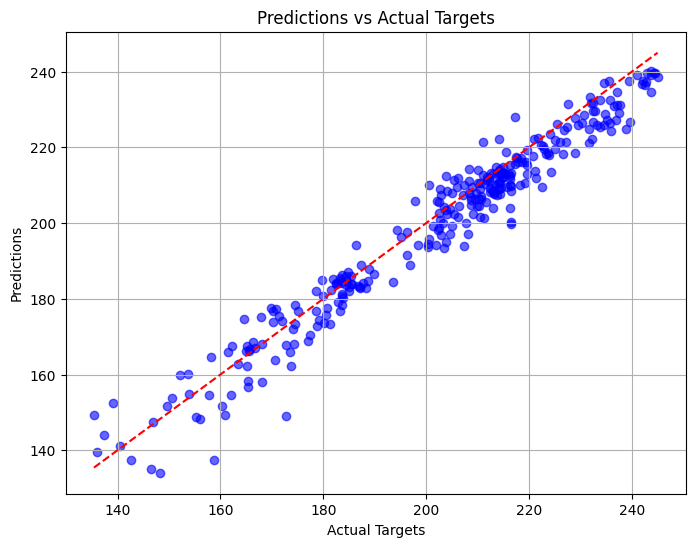

In [150]:
import matplotlib.pyplot as plt

def plot_preds_vs_targets(preds, targets):
    plt.figure(figsize=(8,6))
    plt.scatter(targets, preds, color="blue", alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')  # Perfect prediction line
    plt.xlabel('Actual Targets')
    plt.ylabel('Predictions')
    plt.title('Predictions vs Actual Targets')
    plt.grid(True)
    plt.show()

plot_preds_vs_targets(preds, targets)
